In [1]:
REDUCTION = 'MONTGOMERY' ##### 'MONTGOMERY' or 'PLANTARD'
THS_ID = 0
NSHARES = 3              ##### number of shares in masking scheme (1 for unprotected)
TARGET = 'high'          ##### 'low' or 'high' or 'lowhigh'
MODEL_STR = 'sin'        #### 'packed', 'signed_hw', 'abs', 'opf'

In [2]:
N_STEP = 200              ##### Convergence Step
BATCH_SIZE = 50           ##### Batch size for trace processing
N = 8000                  ##### Number of Traces
FRAME_STEP = None         ##### Step size for frame of power samples. None for all at once

In [3]:
import sys
sys.path.append('../../../../scaredcu/scaredcu')

In [4]:
import scaredcu
import os
import cupy as cp
import util
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
%matplotlib widget

/home/userfoobar/toluntosun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/userfoobar/toluntosun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [5]:
cp.cuda.runtime.setDevice(0)

In [6]:
ths = scaredcu.estraces.ets_format.read_ths_from_ets_file(f'traces/kyber_basemult_{REDUCTION.lower()}_d{NSHARES}_t{THS_ID}.ets')

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
def make_attack_selection(key_index, neg_trick=False):
    if REDUCTION == 'MONTGOMERY':
        reduction = scaredcu.lbc.modop.Reduction_Q2Q2(q=3329,o_dtype='int16') if NSHARES >= 2 and MODEL_STR == 'abs' else None
        # for Montgomery, we perform correction through above reduction
        if TARGET == 'high':
            return scaredcu.lbc.kyber.selection_functions.BaseMulMonty(low=False, high=True, words=cp.array([key_index]), neg_trick=neg_trick, reduction=reduction)
        elif TARGET == 'low':
            return scaredcu.lbc.kyber.selection_functions.BaseMulMonty(low=True, high=False, words=cp.array([key_index]), neg_trick=neg_trick, reduction=reduction)
        elif TARGET == 'lowhigh':
            return scaredcu.lbc.kyber.selection_functions.BaseMulMonty(low=True, high=True, words=cp.array([key_index]), neg_trick=neg_trick, reduction=reduction)
    elif REDUCTION == 'PLANTARD':
        if TARGET == 'high':
            return scaredcu.lbc.kyber.selection_functions.BaseMulPlant(low=False, high=True, words=cp.array([key_index]), neg_trick=neg_trick)
        elif TARGET == 'low':
            return scaredcu.lbc.kyber.selection_functions.BaseMulPlant(low=True, high=False, words=cp.array([key_index]), neg_trick=neg_trick)
        elif TARGET == 'lowhigh':
            return scaredcu.lbc.kyber.selection_functions.BaseMulPlant(low=True, high=True, words=cp.array([key_index]), neg_trick=neg_trick)

In [9]:
if MODEL_STR == 'packed':
    model = scaredcu.models.PackedHammingWeight(expected_dtype='uint16')
elif MODEL_STR == 'signed_hw':
    model = scaredcu.models.SignedHammingWeight(expected_dtype='int16')
elif MODEL_STR == 'abs':
    model = scaredcu.models.AbsoluteValue()
elif MODEL_STR == 'opf':
    model = scaredcu.lbc.OPFTableReduction(scaredcu.lbc.modop.Reduction_Q2Q2(q=3329, dtype='int16'),
                                           fix0=False, d=NSHARES)
elif MODEL_STR == 'sin':
    model = scaredcu.models.Sin(q=3329)
elif MODEL_STR == 'cos':
    model = scaredcu.models.Cos(q=3329)

In [10]:
def filename():
    return f'cpa_results/basemult_{REDUCTION.lower()}_d{NSHARES}_t{str(THS_ID)}_{MODEL_STR}_{TARGET}'

if not os.path.isdir(filename()):
    os.mkdir(filename())

In [11]:
def poi_filename():
    return f'cpa_results_poi/basemult_{REDUCTION.lower()}_d{NSHARES}_t{str(THS_ID)}_{MODEL_STR}_{TARGET}'

results_max_even = cp.load(f'{poi_filename()}/PoI_even.npy')
results_max_odd = cp.load(f'{poi_filename()}/PoI_odd.npy')


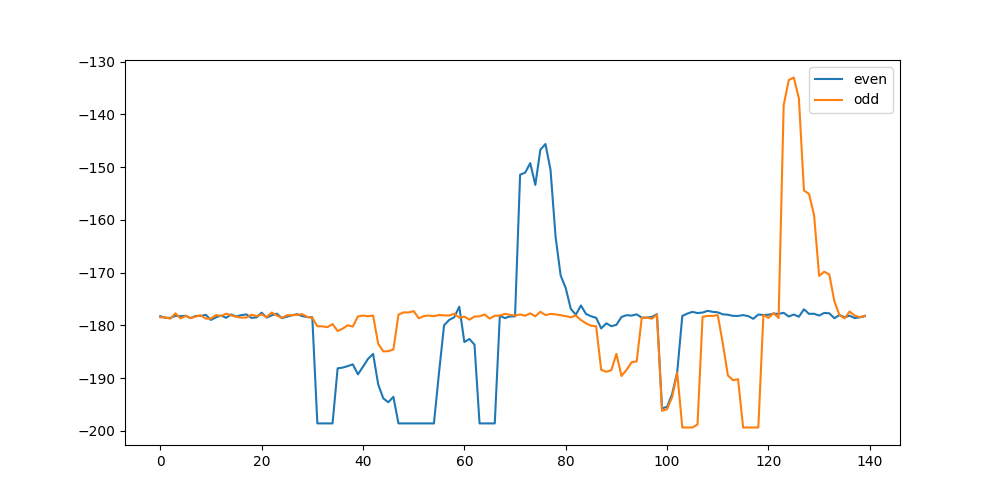

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(results_max_even[-1].get(), label='even')
ax.plot(results_max_odd[-1].get(), label='odd')

ax.legend()

In [13]:
def make_frame_share(key_index, share, offset=0, length=None):
    if REDUCTION == 'MONTGOMERY':
        if NSHARES <= 2:
            R = [93, 9189]
        elif NSHARES == 3:
            R = [110, 9234, 18358]
        K = 140

    elif REDUCTION == 'PLANTARD':
        R = [128, 9740]
        K = 148
    r = range(R[share] + K*(key_index//2), R[share] + K*(key_index//2) + K)
    if length is None:
        return r[offset:]
    else:
        return r[offset:offset+length]

def make_frame(key_index, offset=0, length=None):
    ranges = [make_frame_share(key_index, share, offset, length) for share in range(NSHARES)]
    return sorted(set().union(*ranges))

def get_relative_poi(Ni, key_index):
    if key_index % 2 == 0:
        if REDUCTION == 'MONTGOMERY' and TARGET == 'high':
            # For the trace set with montgomery reduction, we observe three peaks for the even key index. upon observation, we take the second maximum peak (even_poi = 78).
            # We noticed that, the first maximum peak (even_poi = 81) corresponds to TARGET = 'low'.
            # In other words, instead of (s0,s1), (s1*twiddle,s0) shows peak.
            # This observation can be made by comparing the best scoring predictions for these PoIs.
            # One can also simply repeat the attack for each outstanding peak.
            # The ranks of these PoIs can change depending on the data set so the analyst may need to tune it manually at this point
            temp = results_max_even[(Ni//N_STEP) - 1].copy()
            if NSHARES <= 2:
                temp[80:84] = temp.min()
            elif NSHARES == 3:
                temp[75:79] = temp.min()
            return int(temp.argmax().get())
        else:
            return int(results_max_even[(Ni//N_STEP) - 1].argmax().get())
    else:
        return int(results_max_odd[(Ni//N_STEP) - 1].argmax().get())

In [14]:
for Ni in range(N_STEP, N+1, N_STEP):
    print(Ni, get_relative_poi(Ni, 0))

200 51
400 104
600 68
800 92
1000 58
1200 131
1400 106
1600 71
1800 126
2000 119
2200 71
2400 73
2600 73
2800 73
3000 73
3200 71
3400 73
3600 73
3800 73
4000 73
4200 73
4400 73
4600 73
4800 73
5000 73
5200 73
5400 73
5600 73
5800 73
6000 73
6200 73
6400 73
6600 73
6800 73
7000 73
7200 73
7400 73
7600 73
7800 73
8000 73


In [15]:
for Ni in range(N_STEP, N+1, N_STEP):
    print(Ni, get_relative_poi(Ni, 1))

200 48
400 47
600 50
800 50
1000 48
1200 124
1400 125
1600 124
1800 125
2000 125
2200 125
2400 125
2600 125
2800 125
3000 125
3200 125
3400 125
3600 125
3800 125
4000 125
4200 125
4400 125
4600 125
4800 125
5000 125
5200 125
5400 125
5600 125
5800 125
6000 125
6200 125
6400 125
6600 125
6800 125
7000 125
7200 125
7400 125
7600 125
7800 125
8000 125


In [16]:
EVEN_POI_START = 1600 # Trace Number to state that the POI is stable after that
ODD_POI_START = 1200 # Trace Number to state that the POI is stable after that
EVEN_POIS = []
for Ni in range(EVEN_POI_START, N, N_STEP):
    t = get_relative_poi(Ni, 0)
    if t not in EVEN_POIS:
        EVEN_POIS.append(t)
ODD_POIS  = []
for Ni in range(ODD_POI_START, N, N_STEP):
    t = get_relative_poi(Ni, 1)
    if t not in ODD_POIS:
        ODD_POIS.append(t)
print(EVEN_POIS)
print(ODD_POIS)

[71, 126, 119, 73]
[124, 125]


In [17]:
scaredcu.models._HW_LUT = cp.array([0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                     1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                     1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                     2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                     1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                     2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                     2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                     3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8], dtype='uint32')

In [18]:
scaredcu.set_batch_size(BATCH_SIZE)

In [ ]:
q = 3329

s_ntt = ths.s[0] % q

def attack_key_index(key_index):
    print(key_index, s_ntt[key_index*2:key_index*2 + 2], q - s_ntt[key_index*2:key_index*2 + 2])


    relative_pois = EVEN_POIS if key_index % 2 == 0 else ODD_POIS
    frame = make_frame(key_index)
    print(f'Frame: {frame}')
    for poi in relative_pois:
        print(poi)
        frame_poi = make_frame(key_index, offset=poi, length=1)
        print(f'POI: {frame_poi}')

        if NSHARES > 1:
            mean = ths.samples[:N,frame_poi].mean(axis=0)

        cpa = scaredcu.CPAAttackAlternative(selection_function=make_attack_selection(key_index),
                                            model=model,
                                            discriminant=scaredcu.maxabs)
        
        
        for i in tqdm(range(0, N, N_STEP), desc=f'Trace loop key index: {key_index} poi: {poi}'):
            Ni = i + N_STEP
            if NSHARES > 1:
                frames = [range(j, (j+1)) for j in range(NSHARES)]
                pp = [scaredcu.preprocesses.high_order.CenteredProductHigh(frames, mean=mean)]
            else:
                pp = []            
            container = scaredcu.Container(ths[i:Ni], frame=frame_poi, preprocesses=pp)
            cpa.run(container)
            if (poi == get_relative_poi(Ni, key_index)):
                print(f'POI matched ', Ni)
                scores = cp.copy(cpa.scores[:,0])
                scores[0] = 0
                scores_sorted = scores.argsort()[::-1]
                scores_np = scores.get()
                scores_sorted_np = scores_sorted.get()
                util.print_scores_packed(key_index, scores_np, q, scores_sorted_np, l=10)
                util.save_top_scores(f'{filename()}/ki_{key_index}_{(Ni)}', scores_np, scores_sorted_np, l=10)
                guess_low, guess_high = util.unpack_guess(scores_sorted[0], q)

                if (guess_low == (s_ntt[key_index*2]) and  guess_high == (s_ntt[key_index*2 + 1])) or \
                    ((q - guess_low) == (s_ntt[key_index*2]) and  (q - guess_high) == (s_ntt[key_index*2 + 1])):
                    print(f'{key_index} Required traces: {i + N_STEP}')
                    print()
        del cpa

for i in tqdm(range(128)):
    attack_key_index(i)

  0%|          | 0/128 [00:00<?, ?it/s]

0 [1578 1835] [1751 1494]
Frame: [110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271, 9272, 9273, 9274, 9275, 9276, 9277, 92

Trace loop key index: 0 poi: 71:   0%|          | 0/40 [00:00<?, ?it/s]